In [1]:
#Import the librairies
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
#Import the dataset
flight_df = pd.read_csv('/Users/smileloukkade/Downloads/flight_data_2024_sample.csv')

In [3]:
print(flight_df.columns)

flight_df.drop(['taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
    'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'], axis=1, inplace=True)
print(flight_df.columns)

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'],
      dtype='object')
Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'cancelled'],
      dtype='object')


# Remove cancel flights

In [4]:
flight_df = flight_df[flight_df['cancelled'] == 0]

print(flight_df)

      year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0     2024      4            18            4  2024-04-18                MQ   
1     2024      1             1            1  2024-01-01                AA   
2     2024     12            12            4  2024-12-12                9E   
3     2024      4             8            1  2024-04-08                WN   
4     2024      2            16            5  2024-02-16                WN   
...    ...    ...           ...          ...         ...               ...   
9995  2024      1            16            2  2024-01-16                WN   
9996  2024      7             5            5  2024-07-05                AA   
9997  2024      2            28            3  2024-02-28                MQ   
9998  2024      2            18            7  2024-02-18                DL   
9999  2024      3             1            5  2024-03-01                G4   

      op_carrier_fl_num origin       origin_city_name origin_st

In [100]:
#Create new categorical variable
flight_df['small_delay'] = ((flight_df['dep_delay'] > 0) & (flight_df['dep_delay'] < 90)).astype(int)
flight_df['moderate_delay'] = ((flight_df['dep_delay'] >= 90) & (flight_df['dep_delay'] < 180)).astype(int)
flight_df['severe_delay'] = (flight_df['dep_delay'] >= 180).astype(int)
flight_df['no_delay'] = (flight_df['dep_delay'] <= 0).astype(int)

print(flight_df.head())

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm  ...  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  ...   
1              148.0    CLT          Charlotte, NC  North Carolina  ...   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ...   
3             1971.0    OMA              Omaha, NE        Nebraska  ...   
4              862.0    BWI          Baltimore, MD        Maryland  ...   

    dest_state_nm crs_dep_time dep_time  dep_delay  cancelled  small_delay  \
0    South Dakota   

# Data Visualization
1. **Histograms**: to see the spread of numerical data
  - Are most flights early morning or evening?
  - Is there a long tail of super long flights or super busy hours?
  - Do we see any “weird” spikes that could be data entry errors?

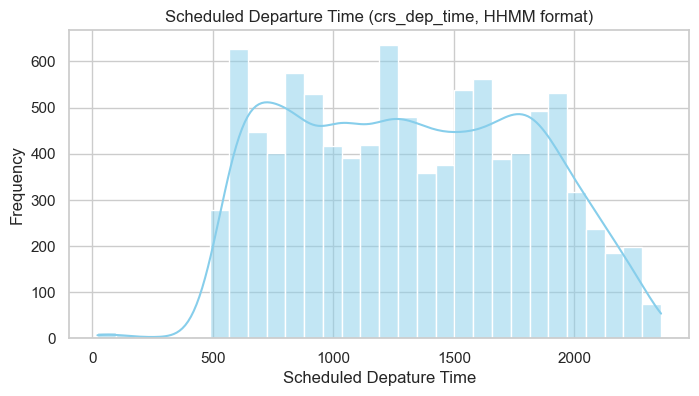

In [101]:
# Set a syle for this visualization
sns.set(style = "whitegrid")

# Create a histogram for "departure time"
plt.figure(figsize=(8,4))
sns.histplot(data=flight_df, x = 'crs_dep_time', bins=30, kde=True, color='skyblue')
plt.title('Scheduled Departure Time (crs_dep_time, HHMM format)')
plt.xlabel('Scheduled Depature Time')
plt.ylabel('Frequency')
plt.show()

### Explanation
the departure time (`crs_dep_time`: HHMM format) run roughly from 0 to 2400, where 

- 0–300 ≈ early morning (midnight–3 AM)
- 600–900 ≈ morning (6–9 AM)
- 1200–1500 ≈ midday (12–3 PM)
- 1800–2100 ≈ evening (6–9 PM)
 
Based on the graph show below, there are two tall clusters of bars:
1. One around the 600–900 range → morning flights
2. Another near 1600–2000 → late afternoon/evening flights

So most flight depart in two main waves: early morning (6-9 AM) and late afternoon to evening (4-8 PM)

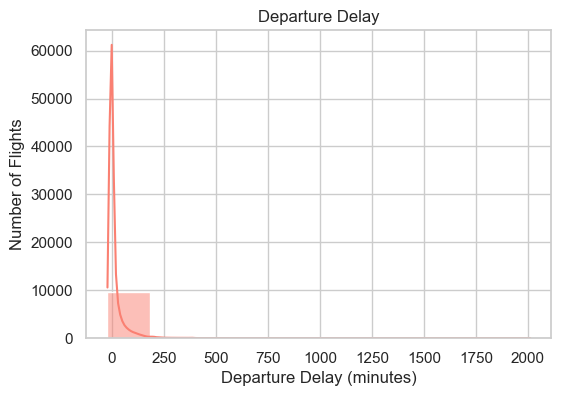

In [102]:
# Histogram for "depature delay"
plt.figure(figsize=(6,4))
sns.histplot(data=flight_df, x='dep_delay', bins=10, kde=True, color='salmon')
plt.title('Departure Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Number of Flights')
plt.show()

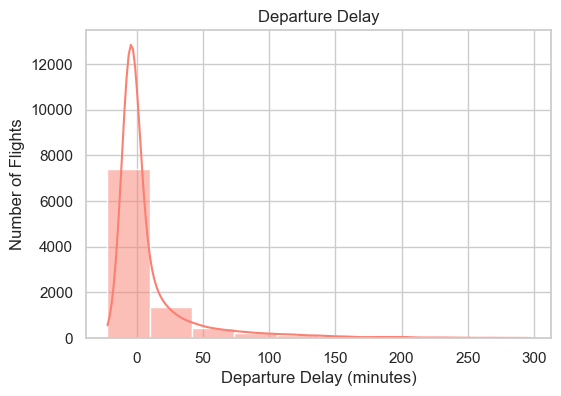

In [103]:
#remove outliers by limitting departure delay in minutes
delay_filtered = flight_df[flight_df['dep_delay'] < 300]

# Histogram for "depature delay"

plt.figure(figsize=(6,4))
sns.histplot(data=delay_filtered, x='dep_delay', bins=10, kde=True, color='salmon')
plt.title('Departure Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Number of Flights')
plt.show()

### Business Interpretation
- The distribution isn't balanced, it's dominated by short delay. Most flights depart on time or with minor delays, but there's a few extreme cases that create a long right tail.
- Severe delays are rare but have outsized operational and customer impact.


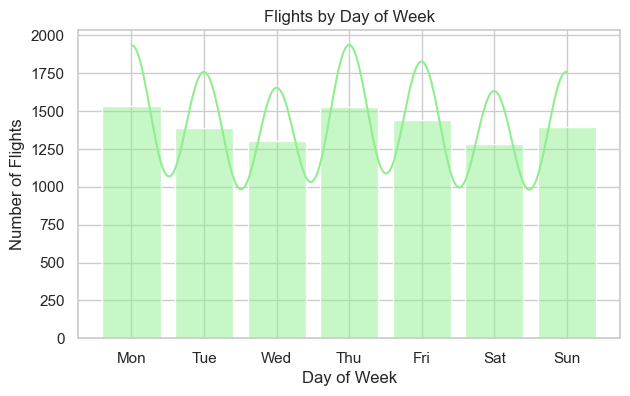

In [104]:
# Histogram for Day of Week (1=Mon,....,7=Sun)
plt.figure(figsize=(7,4))
sns.histplot(data=flight_df, x='day_of_week', bins=7, color='lightgreen', kde=True, shrink=0.8, discrete=True)
plt.title('Flights by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')

#replace 1-7 with weekday labels
plt.xticks(ticks=[1,2,3,4,5,6,7],
           labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

plt.show()



### Explanation
**Flights by Day of Week**
- Monday and Thursday have the highest number of flights (around 1,500+).
- Wednesday and Saturday have the fewest (around 1,300).

### Business Interpretation

- The peak on Mondays and Thursdays reflects heavier business travel demand, while midweek and Saturdays represent lighter operational periods.
- Since these peak days handle more flights, they’re also more prone to congestion and potential delays.

# Box Plot

**Steps:**
- need to combine them into one column (delay_tier) so Seaborn can plot it cleanly on the x-axis (boxplots require one categorical variable, not four separate binaries)
- creating a single column delay tiers from binary columns to make a boxplot (we keep those binary columns since it's useful for ML building later

In [58]:
# create a single column "delay_tier"
conditions = [
    (flight_df['no_delay'] == 1),
    (flight_df['small_delay'] == 1),
    (flight_df['moderate_delay'] == 1),
    (flight_df['severe_delay'] == 1)
]

choices = ['No Delay', 'Small Delay (1-90 min)', 'Moderate Delay (91-180 min)','Severe Delay (>180 min)']

flight_df['delay_tier'] = np.select(conditions, choices, default='Unknown')

In [61]:
#check data
flight_df.head(5)

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,dest_state_nm,crs_dep_time,dep_time,dep_delay,cancelled,small_delay,moderate_delay,severe_delay,no_delay,delay_tier
0,2024,4,18,4,2024-04-18,MQ,3535.0,DFW,"Dallas/Fort Worth, TX",Texas,...,South Dakota,1018,1015.0,-3.0,0,0,0,0,1,No Delay
1,2024,1,1,1,2024-01-01,AA,148.0,CLT,"Charlotte, NC",North Carolina,...,Arizona,1637,1633.0,-4.0,0,0,0,0,1,No Delay
2,2024,12,12,4,2024-12-12,9E,5440.0,CHA,"Chattanooga, TN",Tennessee,...,Georgia,1000,952.0,-8.0,0,0,0,0,1,No Delay
3,2024,4,8,1,2024-04-08,WN,1971.0,OMA,"Omaha, NE",Nebraska,...,Nevada,1330,1334.0,4.0,0,1,0,0,0,Small Delay (1-90 min)
4,2024,2,16,5,2024-02-16,WN,862.0,BWI,"Baltimore, MD",Maryland,...,South Carolina,1340,1333.0,-7.0,0,0,0,0,1,No Delay


/var/folders/3r/2rpxgc855_j0rx6pms6fvgtr0000gn/T/ipykernel_40428/431085749.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=flight_df, x='delay_tier', y='crs_dep_time', palette='pastel')


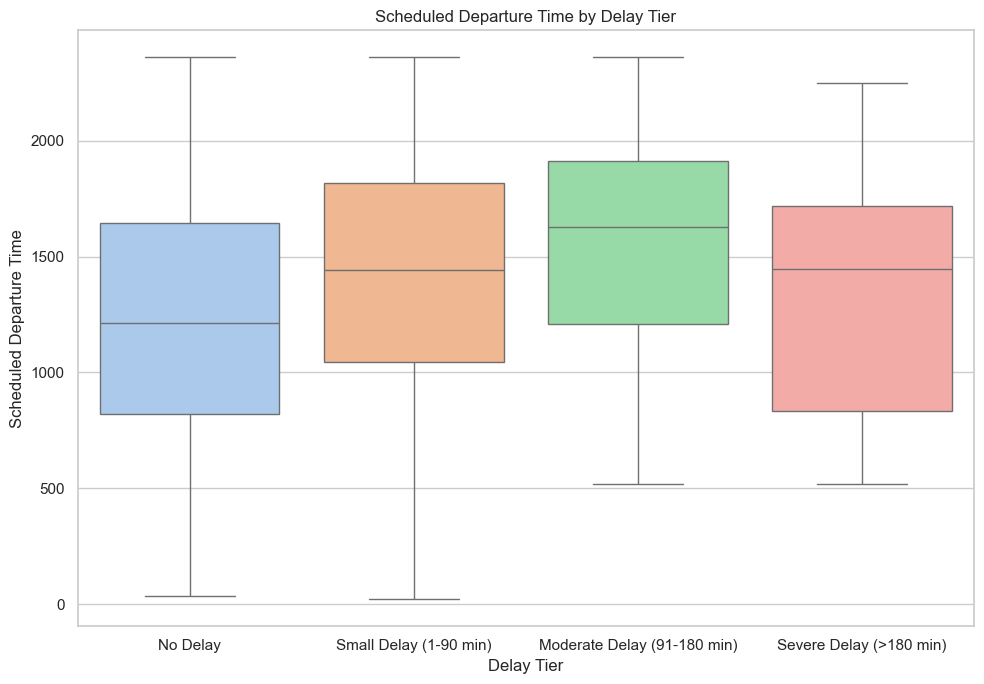

In [71]:
# create boxplot for CRS Departure Time vs Delay Tier
plt.figure(figsize=(10,7))
sns.boxplot(data=flight_df, x='delay_tier', y='crs_dep_time', palette='pastel')
plt.title('Scheduled Departure Time by Delay Tier')
plt.xlabel('Delay Tier')
plt.ylabel('Scheduled Departure Time')
plt.tight_layout()
plt.show()

### Explanation

All four categories have flights spread across almost the full day, but the median scheduled time (the black line inside each box) shifts slightly later as delays become more severe.
The Moderate and Severe Delay boxes have higher medians (around 1500–1700, or 3–5 PM).
The No Delay group’s median is earlier (around 1100–1200, or 11 AM–12 PM).

### Business Interpretation 
- Later median times for severe delays, the flight schedule later in the day tend to face longer delays
- Delays can happen anytime, but afternoon and evening fligts show slightly higher risk

/var/folders/3r/2rpxgc855_j0rx6pms6fvgtr0000gn/T/ipykernel_40428/52389051.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=flight_df, x='delay_tier', y='day_of_week', palette='pastel')


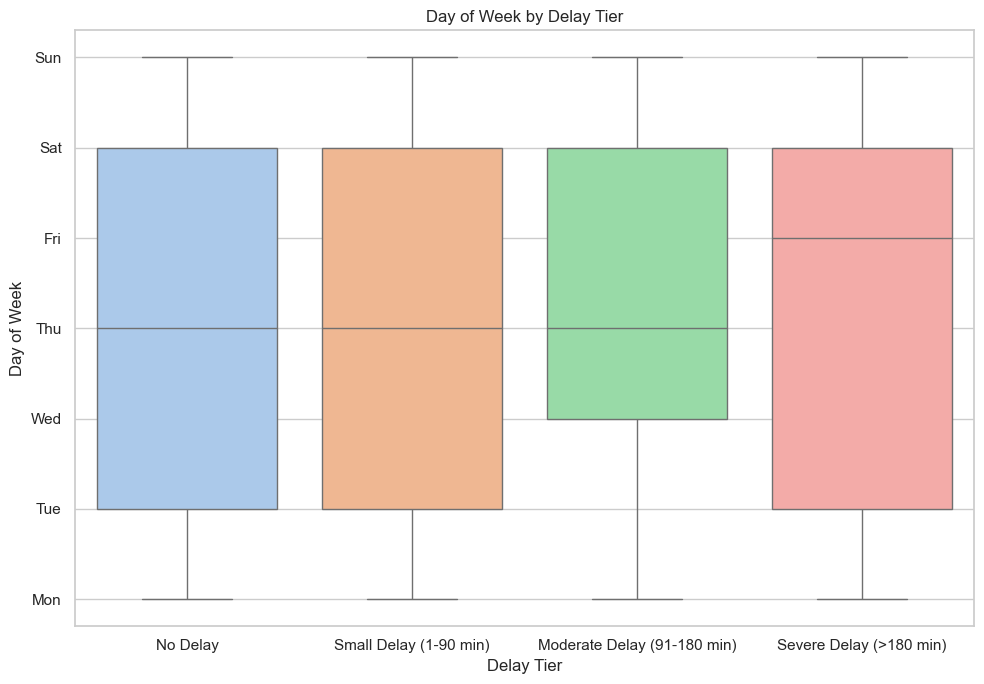

In [106]:
# Boxplot for Day of Week vs Delay Tier
plt.figure(figsize=(10,7))
sns.boxplot(data=flight_df, x='delay_tier', y='day_of_week', palette='pastel')
plt.title('Day of Week by Delay Tier')
plt.xlabel('Delay Tier')
plt.ylabel('Day of Week')

#replace 1-7 with weekday labels
plt.yticks(ticks=[1,2,3,4,5,6,7],
           labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

plt.tight_layout()
plt.show()

### Explanation
The box plot shows that delay severity isn’t confined to any particular weekday, but there’s a mild trend of more severe delays occurring toward the end of the week. However, the slightly higher concentration of **severe delays toward the weekend (Friday–Sunday)** may be related to heavier passenger loads and traffic volume **(peak travel demand)**. Airlines can focus additional resources on end-of-week operations to mitigate these risks.

/var/folders/3r/2rpxgc855_j0rx6pms6fvgtr0000gn/T/ipykernel_40428/847652177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=flight_df, x='delay_tier', y='dep_delay', palette='pastel')


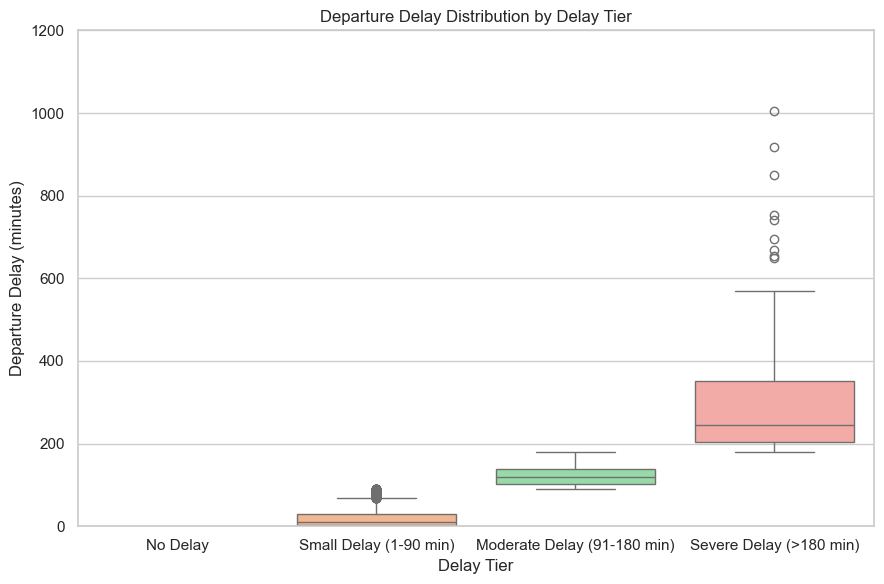

In [108]:
# Check departure delay!
plt.figure(figsize=(9,6))
sns.boxplot(data=flight_df, x='delay_tier', y='dep_delay', palette='pastel')
plt.title('Departure Delay Distribution by Delay Tier')
plt.xlabel('Delay Tier')
plt.ylabel('Departure Delay (minutes)')
plt.ylim(0, 1200)  # zoom in for readability (limit outliers) 
plt.tight_layout()
plt.show()

#we limit ylim 0-1200 (that's why we couldn't see any delay in this chart) <= 0 is No delay

### Explanation

**Note:** This boxplot explain the outliers very well.

- The distinct median levels show that your thresholds (0–90–180+) represent clear differences in delay severity.
- It also helps detect outliers — flights with exceptionally long delays (over 800–1000 minutes) that could influence future modeling.

The box plot shows a clear stepwise increase in delay time from small to severe tiers, suggesting that delay severity categories are well-defined and data-driven. Severe delays are rare but have much larger variation, indicating less predictability and stronger external factors (like weather or cascading flight delays). This insight can help airlines focus mitigation strategies on the long-tail severe delay group.
